# 순차적 데이터(sequential data)
- 순서를 가진 데이터

# 순환신경망(Recurrent Neural Networks)
- 이전 단계의 처리 결과가 다음 단계에 입력이 되는 형태의 신경망

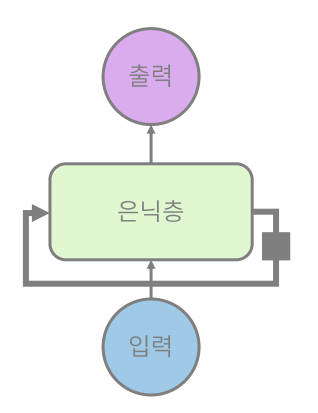

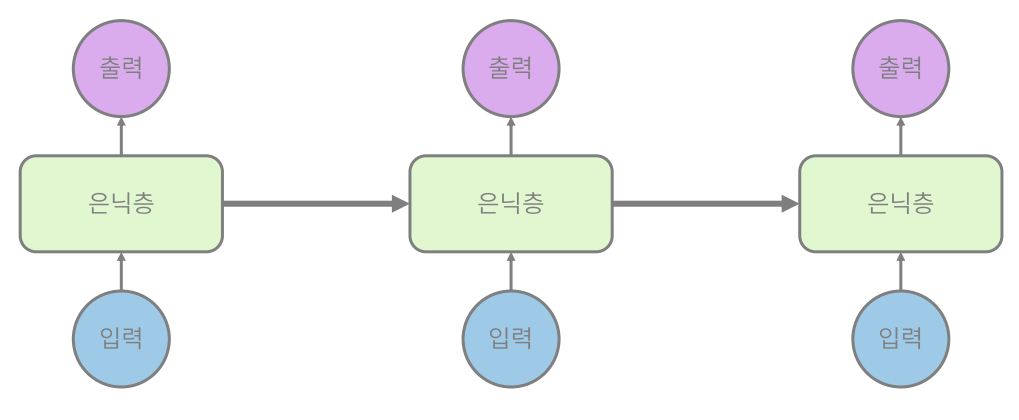

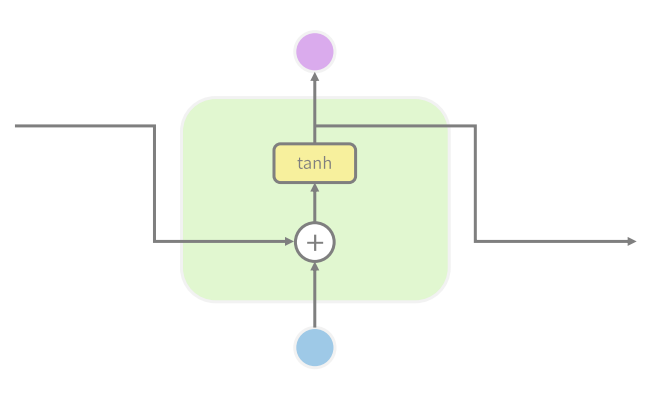

## Vanilla RNN 문제점
- 사라지는 경사
- 장기 의존 관계를 잘 학습할 수 없음



## LSTM(Long Short Term Memory)
- 순환신경망의 사라지는 경사 문제를 해결


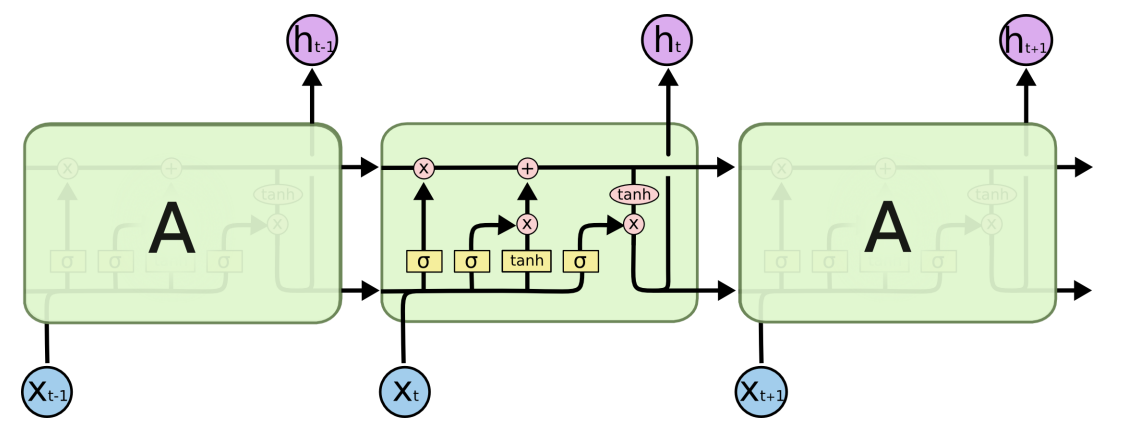

## GRU(Gated Recurrent Unit)
- LSTM 을 간소화
- 은닉상태만을 사용

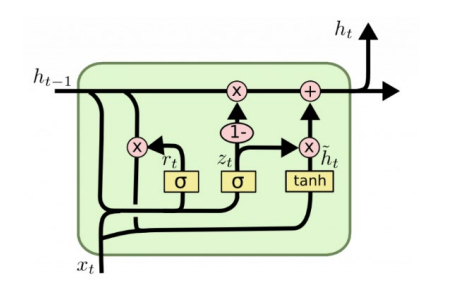

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import random # 시드 고정을 위해
import os # 시드 고정을 위해

In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

- pandas_datareader
    - api를 이용하지 않고 쉽게 주식 데이터를 가져올수 있는 라이브러리
    - https://pandas-datareader.readthedocs.io/en/latest/remote_data.html


In [ ]:
import pandas_datareader.data as web
df = web.DataReader('005930', 'naver', start='2021-01-01', end='2021-12-31')
df

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,81000,84400,80200,83000,38655276
2021-01-05,81600,83900,81600,83900,35335669
2021-01-06,83300,84500,82100,82200,42089013
2021-01-07,82800,84200,82700,82900,32644642
2021-01-08,83300,90000,83000,88800,59013307
...,...,...,...,...,...
2021-12-24,80200,80800,80200,80500,12086380
2021-12-27,80600,80600,79800,80200,10783368
2021-12-28,80200,80400,79700,80300,18226325


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2021-01-04 to 2021-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    248 non-null    object
 1   High    248 non-null    object
 2   Low     248 non-null    object
 3   Close   248 non-null    object
 4   Volume  248 non-null    object
dtypes: object(5)
memory usage: 11.6+ KB


In [ ]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2021-01-04 to 2021-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    248 non-null    int64
 1   High    248 non-null    int64
 2   Low     248 non-null    int64
 3   Close   248 non-null    int64
 4   Volume  248 non-null    int64
dtypes: int64(5)
memory usage: 11.6 KB


In [ ]:
df.head(50)

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,81000,84400,80200,83000,38655276
2021-01-05,81600,83900,81600,83900,35335669
2021-01-06,83300,84500,82100,82200,42089013
2021-01-07,82800,84200,82700,82900,32644642
2021-01-08,83300,90000,83000,88800,59013307
2021-01-11,90000,96800,89500,91000,90306177
2021-01-12,90300,91400,87800,90600,48682416
2021-01-13,89800,91200,89100,89700,36068848
2021-01-14,88700,90000,88700,89700,26393970


In [ ]:
data = df.to_numpy()
data

array([[   81000,    84400,    80200,    83000, 38655276],
       [   81600,    83900,    81600,    83900, 35335669],
       [   83300,    84500,    82100,    82200, 42089013],
       ...,
       [   80200,    80400,    79700,    80300, 18226325],
       [   80200,    80200,    78500,    78800, 19794795],
       [   78900,    79500,    78100,    78300, 14236700]])

- minmax 스케일하기

In [ ]:
mins = data.min(axis=0)
sizes = data.max(axis=0) - mins

train = (data - mins) / sizes
train

array([[0.56944444, 0.54411765, 0.56132075, 0.63963964, 0.36992046],
       [0.59722222, 0.52573529, 0.62735849, 0.68018018, 0.32942521],
       [0.67592593, 0.54779412, 0.6509434 , 0.6036036 , 0.41180797],
       ...,
       [0.53240741, 0.39705882, 0.53773585, 0.51801802, 0.12071157],
       [0.53240741, 0.38970588, 0.48113208, 0.45045045, 0.13984504],
       [0.47222222, 0.36397059, 0.46226415, 0.42792793, 0.07204289]])

In [ ]:
train * sizes + mins # 복원

array([[   81000.,    84400.,    80200.,    83000., 38655276.],
       [   81600.,    83900.,    81600.,    83900., 35335669.],
       [   83300.,    84500.,    82100.,    82200., 42089013.],
       ...,
       [   80200.,    80400.,    79700.,    80300., 18226325.],
       [   80200.,    80200.,    78500.,    78800., 19794795.],
       [   78900.,    79500.,    78100.,    78300., 14236700.]])

In [ ]:
train

array([[0.56944444, 0.54411765, 0.56132075, 0.63963964, 0.36992046],
       [0.59722222, 0.52573529, 0.62735849, 0.68018018, 0.32942521],
       [0.67592593, 0.54779412, 0.6509434 , 0.6036036 , 0.41180797],
       ...,
       [0.53240741, 0.39705882, 0.53773585, 0.51801802, 0.12071157],
       [0.53240741, 0.38970588, 0.48113208, 0.45045045, 0.13984504],
       [0.47222222, 0.36397059, 0.46226415, 0.42792793, 0.07204289]])

- 시계열 데이터 전처리

In [ ]:
seq_len = 10
pred_len = 5

x_list = []
y_list = []

for i in range(seq_len,train.shape[0] + 1 - pred_len):
    x = train[i-seq_len:i]
    y = train[i:i+pred_len,3]

    x_list.append(x)
    y_list.append(y)
x_arr = np.array(x_list)
y_arr = np.array(y_list)

x_arr.shape, y_arr.shape

((234, 10, 5), (234, 5))

In [ ]:
def transform_data(data,mins,sizes,seq_len = 10,pred_len = 5):
    train = (data - mins) / sizes

    x_list = []
    y_list = []

    for i in range(seq_len,train.shape[0] + 1 - pred_len):
        x = train[i-seq_len:i]
        y = train[i:i+pred_len,3]

        x_list.append(x)
        y_list.append(y)
    x_arr = np.array(x_list)
    y_arr = np.array(y_list)

    return x_arr, y_arr
x_arr, y_arr = transform_data(data,mins,sizes)
x_arr.shape, y_arr.shape

((234, 10, 5), (234, 5))

In [ ]:
# x_arr.reshape(x_arr.shape[0],-1)

- 데이터셋 만들기

In [ ]:
class FinanceDataset(torch.utils.data.Dataset):
    def __init__(self,x,y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        item = {}
        x = torch.Tensor(self.x[idx])
        item["x"] = x

        if self.y is not None:
            y = torch.Tensor(self.y[idx])
            item["y"] = y

        return item


In [ ]:
dt = FinanceDataset(x_arr,y_arr)
dl = torch.utils.data.DataLoader(dt,batch_size=1,shuffle=False)

batch = next(iter(dl))
batch

{'x': tensor([[[0.5694, 0.5441, 0.5613, 0.6396, 0.3699],
          [0.5972, 0.5257, 0.6274, 0.6802, 0.3294],
          [0.6759, 0.5478, 0.6509, 0.6036, 0.4118],
          [0.6528, 0.5368, 0.6792, 0.6351, 0.2966],
          [0.6759, 0.7500, 0.6934, 0.9009, 0.6183],
          [0.9861, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 0.8015, 0.9198, 0.9820, 0.4922],
          [0.9769, 0.7941, 0.9811, 0.9414, 0.3384],
          [0.9259, 0.7500, 0.9623, 0.9414, 0.2203],
          [0.9769, 0.8162, 0.9292, 0.8649, 0.3062]]]),
 'y': tensor([[0.7297, 0.8198, 0.8288, 0.8694, 0.8108]])}

In [ ]:
batch["x"]

tensor([[[0.5694, 0.5441, 0.5613, 0.6396, 0.3699],
         [0.5972, 0.5257, 0.6274, 0.6802, 0.3294],
         [0.6759, 0.5478, 0.6509, 0.6036, 0.4118],
         [0.6528, 0.5368, 0.6792, 0.6351, 0.2966],
         [0.6759, 0.7500, 0.6934, 0.9009, 0.6183],
         [0.9861, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 0.8015, 0.9198, 0.9820, 0.4922],
         [0.9769, 0.7941, 0.9811, 0.9414, 0.3384],
         [0.9259, 0.7500, 0.9623, 0.9414, 0.2203],
         [0.9769, 0.8162, 0.9292, 0.8649, 0.3062]]])

In [ ]:
batch["x"].shape

torch.Size([1, 10, 5])

# LSTM Layer
- input_size : 피쳐개수
- hidden_size : 은닉상태의 출력개수
- batch_first : 입력 데이터가 batch 먼저일 경우 True , 입력길이가 먼저일경우 False

In [ ]:
# (seq, batch  , features)
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,batch_first=False)

output, (hn,cn) =  lstm_layer(batch["x"].permute(1,0,2))
output.shape

torch.Size([10, 1, 16])

In [ ]:
# ( batch  ,seq, features)
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,batch_first=True)
output, (hn,cn) =  lstm_layer(batch["x"])
output.shape

torch.Size([1, 10, 16])

In [ ]:
hn.shape # (n_layer,1,feature)

torch.Size([1, 1, 16])

In [ ]:
cn.shape

torch.Size([1, 1, 16])

In [ ]:
output[:,-1]

tensor([[ 0.1415,  0.0217,  0.0352, -0.0239,  0.0148, -0.0914,  0.2661, -0.0619,
          0.0069, -0.2520, -0.0927,  0.0396, -0.0064,  0.1120,  0.1351, -0.2672]],
       grad_fn=<SelectBackward0>)

In [ ]:
hn

tensor([[[ 0.1415,  0.0217,  0.0352, -0.0239,  0.0148, -0.0914,  0.2661,
          -0.0619,  0.0069, -0.2520, -0.0927,  0.0396, -0.0064,  0.1120,
           0.1351, -0.2672]]], grad_fn=<StackBackward0>)

- num_layers : 반복 레이어수
    - 순환신경망 층을 여러개 쌓을 수 있음

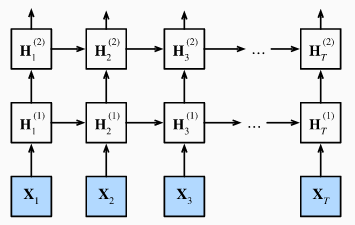

In [ ]:
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,num_layers=2,batch_first=True)
output, (hn,cn) = lstm_layer(batch["x"])

output.shape , hn.shape , cn.shape

(torch.Size([1, 10, 16]), torch.Size([2, 1, 16]), torch.Size([2, 1, 16]))

In [ ]:
output[:,-1]

tensor([[ 0.0076, -0.0451, -0.1622,  0.0548, -0.1787, -0.0283,  0.0217, -0.0809,
          0.1681,  0.1267,  0.0600, -0.0523, -0.1599,  0.0128, -0.0688,  0.0132]],
       grad_fn=<SelectBackward0>)

In [ ]:
hn[1]

tensor([[ 0.0076, -0.0451, -0.1622,  0.0548, -0.1787, -0.0283,  0.0217, -0.0809,
          0.1681,  0.1267,  0.0600, -0.0523, -0.1599,  0.0128, -0.0688,  0.0132]],
       grad_fn=<SelectBackward0>)

In [ ]:
output.shape

torch.Size([1, 10, 16])

In [ ]:
output.view(output.shape[0],-1)

tensor([[-0.0269, -0.0495, -0.0731,  0.0299, -0.1011,  0.0088, -0.0143, -0.0279,
          0.0737,  0.0502,  0.0265,  0.0102, -0.0919,  0.0031, -0.0172,  0.0027,
         -0.0221, -0.0597, -0.1114,  0.0442, -0.1449,  0.0028, -0.0172, -0.0478,
          0.1115,  0.0824,  0.0365,  0.0004, -0.1259,  0.0076, -0.0380,  0.0042,
         -0.0126, -0.0585, -0.1326,  0.0508, -0.1640, -0.0031, -0.0140, -0.0597,
          0.1322,  0.1010,  0.0421, -0.0117, -0.1405,  0.0109, -0.0519,  0.0042,
         -0.0053, -0.0553, -0.1449,  0.0543, -0.1716, -0.0086, -0.0075, -0.0685,
          0.1442,  0.1123,  0.0457, -0.0221, -0.1486,  0.0129, -0.0599,  0.0060,
         -0.0004, -0.0492, -0.1530,  0.0564, -0.1763, -0.0135, -0.0024, -0.0718,
          0.1529,  0.1185,  0.0460, -0.0284, -0.1538,  0.0139, -0.0645,  0.0041,
          0.0037, -0.0423, -0.1581,  0.0558, -0.1806, -0.0169,  0.0013, -0.0691,
          0.1601,  0.1214,  0.0471, -0.0322, -0.1562,  0.0149, -0.0668, -0.0005,
          0.0060, -0.0410, -

- bidirectional : 양방향 여부, 기본값은 False


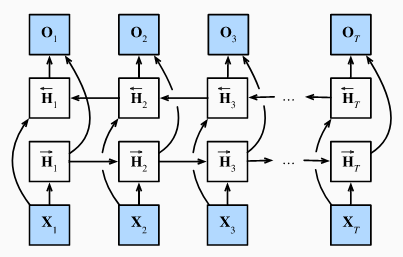

In [ ]:
batch["x"]

tensor([[[0.5694, 0.5441, 0.5613, 0.6396, 0.3699],
         [0.5972, 0.5257, 0.6274, 0.6802, 0.3294],
         [0.6759, 0.5478, 0.6509, 0.6036, 0.4118],
         [0.6528, 0.5368, 0.6792, 0.6351, 0.2966],
         [0.6759, 0.7500, 0.6934, 0.9009, 0.6183],
         [0.9861, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 0.8015, 0.9198, 0.9820, 0.4922],
         [0.9769, 0.7941, 0.9811, 0.9414, 0.3384],
         [0.9259, 0.7500, 0.9623, 0.9414, 0.2203],
         [0.9769, 0.8162, 0.9292, 0.8649, 0.3062]]])

In [ ]:
reset_seeds(SEED)
lstm_layer = torch.nn.LSTM(x_arr.shape[2],16,bidirectional=True,batch_first=True)
output , (hn,cn)= lstm_layer(batch["x"])

output.shape,hn.shape,cn.shape

(torch.Size([1, 10, 32]), torch.Size([2, 1, 16]), torch.Size([2, 1, 16]))

# GRU Layer
- 파라미터는 동일하지만 출력에 cell state 가 없다.

In [ ]:
reset_seeds(SEED)
gru_layer = torch.nn.GRU(x_arr.shape[2],16,batch_first=True)
output, hn = gru_layer(batch["x"])
output.shape, hn.shape

(torch.Size([1, 10, 16]), torch.Size([1, 1, 16]))

In [ ]:
class RNNModel(torch.nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.rnn_layer = torch.nn.LSTM(input_size,hidden_size,batch_first=True)
        self.linear_layer = torch.nn.Linear(hidden_size,hidden_size//2)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_size//2,5)
    def forward(self,x):
        output , (hn,cn) = self.rnn_layer(x)
        x = output[:,-1]
        x = self.linear_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchinfo
model = RNNModel(x_arr.shape[2],16)
torchinfo.summary(model,(32,x_arr.shape[1],x_arr.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [32, 5]                   --
├─LSTM: 1-1                              [32, 10, 16]              1,472
├─Linear: 1-2                            [32, 8]                   136
├─ReLU: 1-3                              [32, 8]                   --
├─Linear: 1-4                            [32, 5]                   45
Total params: 1,653
Trainable params: 1,653
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred,batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [ ]:
@torch.no_grad()
def test_loop(dataloader,model,loss_fn,device):
    epoch_loss = 0
    model.eval()

    pred_list = []
    for batch in dataloader:
        pred = model(batch["x"].to(device))

        if batch.get("y") is not None:
            loss = loss_fn(pred,batch["y"].to(device))
            epoch_loss += loss.item()

        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list)
    return epoch_loss,pred

- 하이퍼 파라미터

In [ ]:
n_splits = 5
num_features = x_arr.shape[2]
hidden_size = 16
batch_size = 32
epochs = 500
loss_fn = torch.nn.MSELoss()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

In [ ]:
is_holdout = False

reset_seeds(SEED)
best_score_list = []
for i,(tri,vai) in enumerate(cv.split(x_arr)):
    model = RNNModel(num_features,hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    # dataset
    train_dt = FinanceDataset(x_arr[tri],y_arr[tri])
    valid_dt = FinanceDataset(x_arr[vai],y_arr[vai])

    # dataloader
    train_dl = torch.utils.data.DataLoader(train_dt,batch_size=batch_size,shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt,batch_size=batch_size,shuffle=False)

    best_score = np.inf
    patience = 0 
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss,pred = test_loop(valid_dl,model,loss_fn,device)
        pred = pred * sizes[3] + mins[3]
        true = y_arr[vai] * sizes[3] + mins[3]
        score = mean_absolute_error(true,pred)
        patience += 1
        if best_score > score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 5:
            break
    print(f"Fold ({i}), BEST MAE: {best_score}")
    best_score_list.append(best_score)
    if is_holdout:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

Fold (0), BEST MAE: 1108.7391450922541


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (1), BEST MAE: 1317.894710719332


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (2), BEST MAE: 1481.7823304521276


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (3), BEST MAE: 1212.5271920711434


  0%|          | 0/500 [00:00<?, ?it/s]

Fold (4), BEST MAE: 1400.4468325407609


In [ ]:
np.mean(best_score_list)

1304.2780421751236

# 실제 3개월동안 매일 미래의 5일씩 예측

In [ ]:
from datetime import datetime, timedelta
start = datetime(2022,1,1) - timedelta(days=seq_len)
start = start.strftime("%Y-%m-%d")
start

'2021-12-22'

In [ ]:
test_df = web.DataReader('005930', 'naver', start=start, end='2022-03-31')
test_df = test_df.astype(int)
test_data = test_df.to_numpy()
x_test , y_test = transform_data(test_data,mins,sizes)
x_test.shape, y_test.shape

((52, 10, 5), (52, 5))

In [ ]:
test_dt = FinanceDataset(x_test)
test_dl = torch.utils.data.DataLoader(test_dt,batch_size=batch_size,shuffle=False)

pred_list = []
for i in range(n_splits):
    model = RNNModel(num_features,hidden_size).to(device)
    state_dict = torch.load(f"model_{i}.pth")
    model.load_state_dict(state_dict)
    _ , pred = test_loop(test_dl,model,loss_fn,device)
    pred_list.append(pred)

pred = np.mean(pred_list,axis=0)
pred = pred * sizes[3] + mins[3]
pred

array([[78386.9453125 , 78288.54003906, 78357.94726562, 78393.17871094,
        78265.06933594],
       [77836.69726562, 77713.5078125 , 77795.57421875, 77827.14941406,
        77725.91503906],
       [77912.14648438, 77734.29492188, 77833.92480469, 77830.09375   ,
        77740.30957031],
       [77988.37890625, 77792.18847656, 77897.28613281, 77843.28417969,
        77782.52441406],
       [78277.88183594, 78068.05957031, 78171.52539062, 78101.98339844,
        78028.14355469],
       [78668.51757812, 78466.41113281, 78561.34960938, 78472.33105469,
        78389.78027344],
       [78628.19628906, 78471.65332031, 78567.32226562, 78500.44042969,
        78388.37304688],
       [78249.21191406, 78123.87109375, 78220.03808594, 78182.60644531,
        78063.05273438],
       [77988.86328125, 77855.91308594, 77965.29296875, 77934.8125    ,
        77823.47363281],
       [77738.19921875, 77594.97558594, 77729.37304688, 77695.984375  ,
        77594.73144531],
       [77273.921875  , 77129.

In [ ]:
true = y_test * sizes[3] + mins[3]
mean_absolute_error(true,pred)

1319.2947810246394